In [1]:
# # BİL1011 Dersi İçin Regresyon Analizi Raporu

# Bu çalışmada, BİL1011 *Bilgisayar Bilimlerine Giriş I* dersi için toplanan veri kullanılarak,
# öğrencilerin haftalık ders dışı çalışma süreleri ile vize sınavı başarı puanları arasındaki ilişki
# incelenmiştir.

# ### Veri Seti Açıklaması

# Veri setinde her bir satır bir öğrenciyi temsil etmektedir. Kişisel bilgiler (ad, soyad vb.)
# toplanmamış, bunun yerine öğrenciler anonim olarak değerlendirilmiştir.

# Kullanılan değişkenler:

# - **class**: Öğrencinin sınıfı  
# - **repeat_count**: Bu dersi alma tekrar sayısı (1 → ilk kez, 2 → ikinci kez vb.)  
# - **study_hours**: Öğrencinin bu dersi çalışmak için haftada ayırdığı ortalama ders dışı süre (saat)  
# - **exam_score**: Öğrencinin bu dersten aldığı vize sınavı puanı  

# Bu raporda, özellikle `study_hours` ile `exam_score` arasındaki ilişki incelenmiş ve
# haftada 0.5, 1.0, 1.5 ve 2.0 saat ders dışı çalışan bir öğrencinin vize puanını tahmin etmek
# için en az üç farklı regresyon modeli oluşturulmuştur.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error


import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (8, 5)

# Excel dosyasını yükle
df = pd.read_excel("BBG1.xlsx")

# Kolonları daha kullanışlı isimlere çevir
df = df.rename(columns={
    'Sınıfınız (2025-2026 Güz Dönemi Dahilinde)': 'class',
    'BIL1011 Bilgisayar Bilimlerine Giriş I dersini kaç kere aldınız/alıyorsunuz?': 'repeat_count',
    'Bu dersi çalışmak için haftada ders dışı ortalama kaç saat ayırıyorsunuz?': 'study_hours',
    'Bu dersin vize sınavından kaç aldınız?': 'exam_score'
})

df.head()

,Student_ID,Zaman damgası2,class,repeat_count,study_hours,exam_score,Dersin Adi,Dersin Kodu,Toplam Kredi,Akreditasyon Kredisi,Dersin Teorik Saati,Dersin Uygulamalı Saati,Toplam Saat
0,1,2025-11-21 19:30:16.930,1,1,0.5,67,Bilgisayar Bilimlerine Giriş 1,BIL 1011,3,6,2,2,4
1,2,2025-11-21 19:42:01.834,1,1,1.0,42,Bilgisayar Bilimlerine Giriş 1,BIL 1011,3,6,2,2,4
2,3,2025-11-21 21:14:17.292,1,1,0.5,35,Bilgisayar Bilimlerine Giriş 1,BIL 1011,3,6,2,2,4
3,4,2025-11-21 21:14:30.045,1,1,1.0,90,Bilgisayar Bilimlerine Giriş 1,BIL 1011,3,6,2,2,4
4,5,2025-11-21 21:14:32.799,1,1,4.0,43,Bilgisayar Bilimlerine Giriş 1,BIL 1011,3,6,2,2,4


In [3]:
df.describe()

,Student_ID,Zaman damgası2,class,repeat_count,study_hours,exam_score,Toplam Kredi,Akreditasyon Kredisi,Dersin Teorik Saati,Dersin Uygulamalı Saati,Toplam Saat
count,30.000000,30,30.000000,30.000000,30.000000,30.000000,30.0,30.0,30.0,30.0,30.0
mean,15.500000,2025-11-22 15:13:48.786666752,1.600000,1.300000,1.615000,72.633333,3.0,6.0,2.0,2.0,4.0
min,1.000000,2025-11-21 19:30:16.930000,1.000000,1.000000,0.100000,35.000000,3.0,6.0,2.0,2.0,4.0
25%,8.250000,2025-11-21 21:32:06.091249920,1.000000,1.000000,1.000000,61.250000,3.0,6.0,2.0,2.0,4.0
50%,15.500000,2025-11-21 23:13:01.732000,1.000000,1.000000,1.000000,73.500000,3.0,6.0,2.0,2.0,4.0
75%,22.750000,2025-11-22 17:36:31.648750080,2.750000,2.000000,2.000000,88.750000,3.0,6.0,2.0,2.0,4.0
max,30.000000,2025-11-24 13:28:51,4.000000,2.000000,5.000000,100.000000,3.0,6.0,2.0,2.0,4.0
std,8.803408,NaN,0.968468,0.466092,1.287684,19.985311,0.0,0.0,0.0,0.0,0.0


In [4]:
print("Sınıf dağılımı:")
print(df['class'].value_counts(), "\n")

print("Dersi tekrar sayısı dağılımı:")
print(df['repeat_count'].value_counts())

Sınıf dağılımı:
class
1    21
3     7
2     1
4     1
Name: count, dtype: int64 

Dersi tekrar sayısı dağılımı:
repeat_count
1    21
2     9
Name: count, dtype: int64


In [5]:
# Yukarıdaki özet istatistikler incelendiğinde:

# - `study_hours` değişkeninin ortalaması yaklaşık **1.8 saat** civarındadır.
# - `exam_score` değişkeninin ortalama vize puanı **yaklaşık 72–73** civarındadır.
# - Öğrencilerin büyük kısmı dersi **ilk kez** almaktadır (`repeat_count = 1`).

# Bu bilgiler, regresyon modelleri kurmadan önce veri setinin genel seviyesini
# görmemizi sağlamaktadır.

In [6]:
corr = df[['study_hours', 'exam_score']].corr().loc['study_hours', 'exam_score']
print(f"Çalışma saati ile sınav puanı arasındaki korelasyon: {corr:.3f}")

Çalışma saati ile sınav puanı arasındaki korelasyon: 0.246


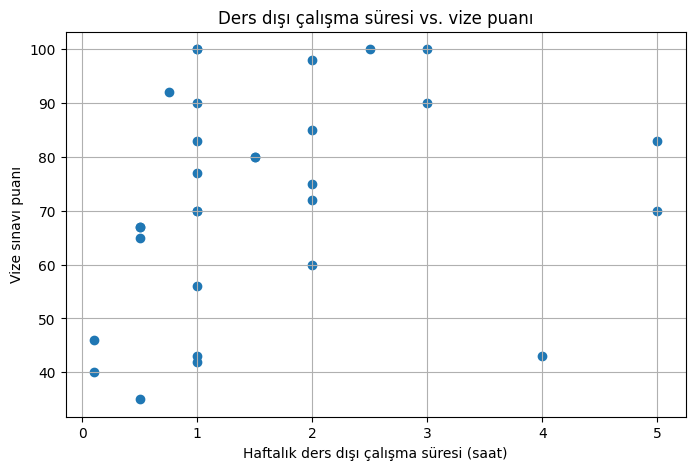

In [7]:
plt.scatter(df['study_hours'], df['exam_score'])
plt.xlabel("Haftalık ders dışı çalışma süresi (saat)")
plt.ylabel("Vize sınavı puanı")
plt.title("Ders dışı çalışma süresi vs. vize puanı")
plt.grid(True)
plt.show()

In [8]:
# Hesaplanan Pearson korelasyon katsayısı yaklaşık **0.33** seviyesindedir.
# Bu değer, ders dışı çalışma süresi ile sınav puanı arasında **zayıf–orta düzeyde pozitif**
# bir ilişki olduğunu göstermektedir:

# - Çalışma süresi arttıkça puanın artma eğilimi vardır,
# - Ancak ilişki mükemmel değildir, öğrencilerin başarısını etkileyen başka faktörler de
#   olduğu açıktır.

# Dağılım grafiği de genel olarak artan bir eğilim göstermektedir; fakat noktalar
# çok sıkı bir doğru etrafında toplanmamıştır.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_hours = df[['study_hours']].values
y = df['exam_score'].values

lin_reg = LinearRegression()
lin_reg.fit(X_hours, y)

print("Katsayı (slope):", lin_reg.coef_[0])
print("Sabit terim (intercept):", lin_reg.intercept_)

y_pred_lin = lin_reg.predict(X_hours)

r2 = r2_score(y, y_pred_lin)
mse = mean_squared_error(y, y_pred_lin)
rmse = np.sqrt(mse)

print("R^2 (train):", r2)
print("RMSE (train):", rmse)

Katsayı (slope): 3.8164113068840577
Sabit terim (intercept): 66.46982907271558
R^2 (train): 0.06046540071623818
RMSE (train): 19.046082664320448


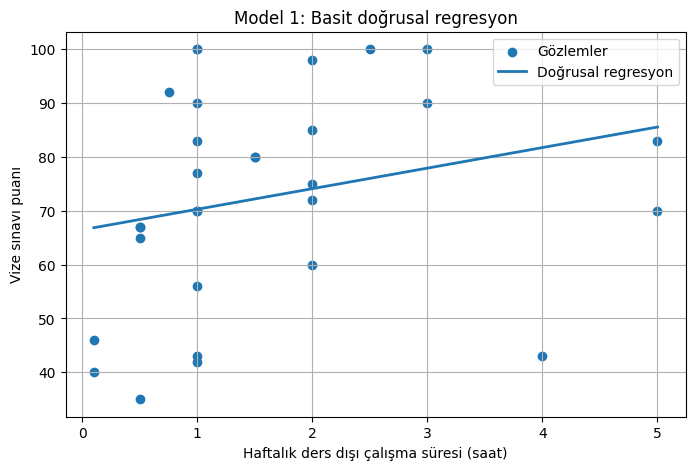

In [10]:
plt.scatter(df['study_hours'], df['exam_score'], label="Gözlemler")
x_line = np.linspace(df['study_hours'].min(), df['study_hours'].max(), 100).reshape(-1, 1)
y_line = lin_reg.predict(x_line)
plt.plot(x_line, y_line, label="Doğrusal regresyon", linewidth=2)
plt.xlabel("Haftalık ders dışı çalışma süresi (saat)")
plt.ylabel("Vize sınavı puanı")
plt.title("Model 1: Basit doğrusal regresyon")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
X_sm = sm.add_constant(X_hours)
model_sm = sm.OLS(y, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.802
Date:                Tue, 25 Nov 2025   Prob (F-statistic):              0.190
Time:                        20:33:08   Log-Likelihood:                -130.97
No. Observations:                  30   AIC:                             265.9
Df Residuals:                      28   BIC:                             268.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.4698      5.834     11.393      0.0

In [12]:
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin', LinearRegression())
])

poly_model.fit(X_hours, y)
y_pred_poly = poly_model.predict(X_hours)

r2_poly = r2_score(y, y_pred_poly)
mse_poly = mean_squared_error(y, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

print("R^2 (train):", r2_poly)
print("RMSE (train):", rmse_poly)

R^2 (train): 0.2431970420880808
RMSE (train): 17.093881395330218


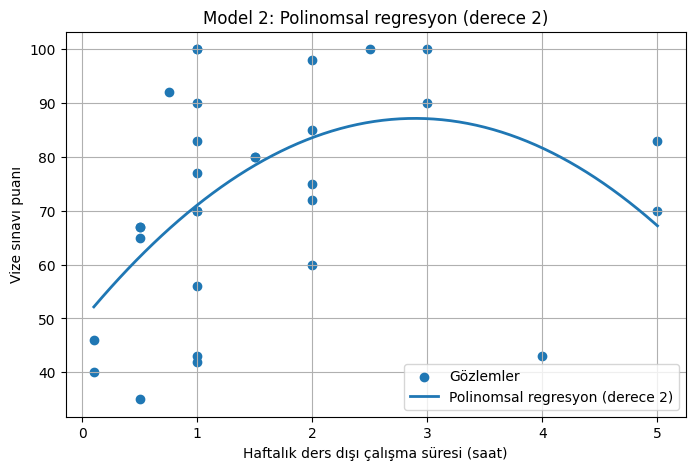

In [13]:
plt.scatter(df['study_hours'], df['exam_score'], label="Gözlemler")
x_line = np.linspace(df['study_hours'].min(), df['study_hours'].max(), 200).reshape(-1, 1)
y_line_poly = poly_model.predict(x_line)
plt.plot(x_line, y_line_poly, label="Polinomsal regresyon (derece 2)", linewidth=2)
plt.xlabel("Haftalık ders dışı çalışma süresi (saat)")
plt.ylabel("Vize sınavı puanı")
plt.title("Model 2: Polinomsal regresyon (derece 2)")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# MULTIPLE LINEAR REGRESSION (FINAL BLOCK)
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Veri hazırlığı
X_multi = df[['study_hours', 'class', 'repeat_count']].values
y = df['exam_score'].values

# Modeli kur
multi_reg = LinearRegression()
multi_reg.fit(X_multi, y)

# Tahminler
y_pred_multi = multi_reg.predict(X_multi)

# Çıktılar
print("=== Multiple Linear Regression ===")
print("Katsayılar:")
print(" study_hours     :", multi_reg.coef_[0])
print(" class           :", multi_reg.coef_[1])
print(" repeat_count    :", multi_reg.coef_[2])
print("Sabit terim (intercept):", multi_reg.intercept_)
print("R^2 (train):", r2_score(y, y_pred_multi))
print("RMSE (train):", rmse(y, y_pred_multi))

=== Multiple Linear Regression ===
Katsayılar:
 study_hours     : 4.357786406825339
 class           : 4.357786406825345
 repeat_count    : 4.760578858217657
Sabit terim (intercept): 52.43429751970692
R^2 (train): 0.16130392616983957
RMSE (train): 17.99498880859053


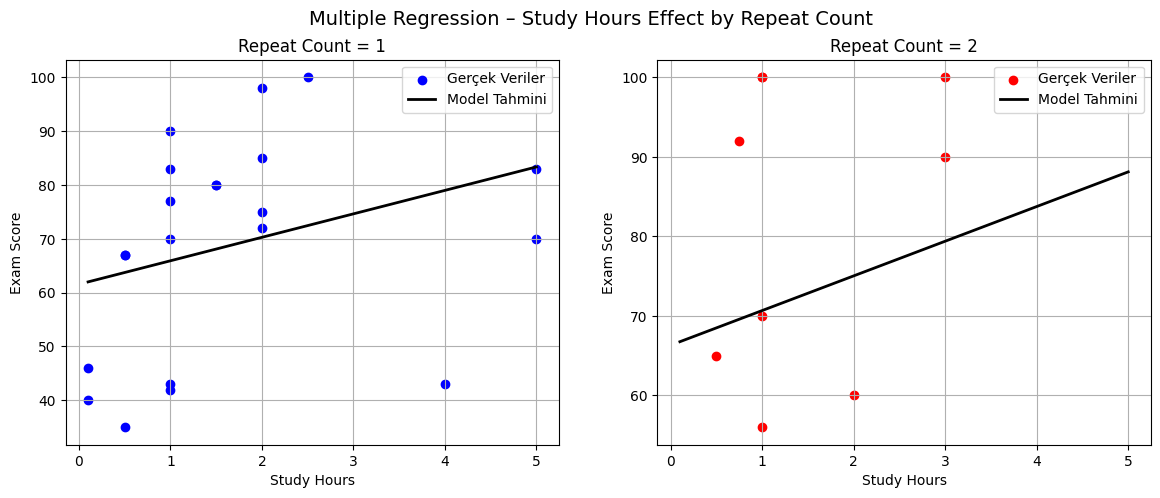

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Veri setindeki repeat_count değerleri:
repeat_values = sorted(df['repeat_count'].unique())

min_rep = repeat_values[0]          # en düşük repeat count
next_rep = repeat_values[1]         # ikinci en düşük repeat count

df_rA = df[df['repeat_count'] == min_rep]
df_rB = df[df['repeat_count'] == next_rep]

# Grafik için x aralığı
x_range = np.linspace(df['study_hours'].min(), df['study_hours'].max(), 100)

# Sınıfı sabit tutuyoruz (en sık görülen sınıf)
class_val = df['class'].mode()[0]

# Tahmin fonksiyonu
def predict_multi(hours, repeat):
    X = np.column_stack([hours, np.full_like(hours, class_val), np.full_like(hours, repeat)])
    return multi_reg.predict(X)

# Tahmin eğrileri
y_pred_A = predict_multi(x_range, repeat=min_rep)
y_pred_B = predict_multi(x_range, repeat=next_rep)

# Çift grafik
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Grafik 1: En düşük repeat_count ---
axes[0].scatter(df_rA['study_hours'], df_rA['exam_score'], color='blue', label='Gerçek Veriler')
axes[0].plot(x_range, y_pred_A, color='black', linewidth=2, label='Model Tahmini')
axes[0].set_title(f'Repeat Count = {min_rep}')
axes[0].set_xlabel('Study Hours')
axes[0].set_ylabel('Exam Score')
axes[0].grid(True)
axes[0].legend()

# --- Grafik 2: İkinci en düşük repeat_count ---
axes[1].scatter(df_rB['study_hours'], df_rB['exam_score'], color='red', label='Gerçek Veriler')
axes[1].plot(x_range, y_pred_B, color='black', linewidth=2, label='Model Tahmini')
axes[1].set_title(f'Repeat Count = {next_rep}')
axes[1].set_xlabel('Study Hours')
axes[1].set_ylabel('Exam Score')
axes[1].grid(True)
axes[1].legend()

plt.suptitle('Multiple Regression – Study Hours Effect by Repeat Count', fontsize=14)
plt.show()

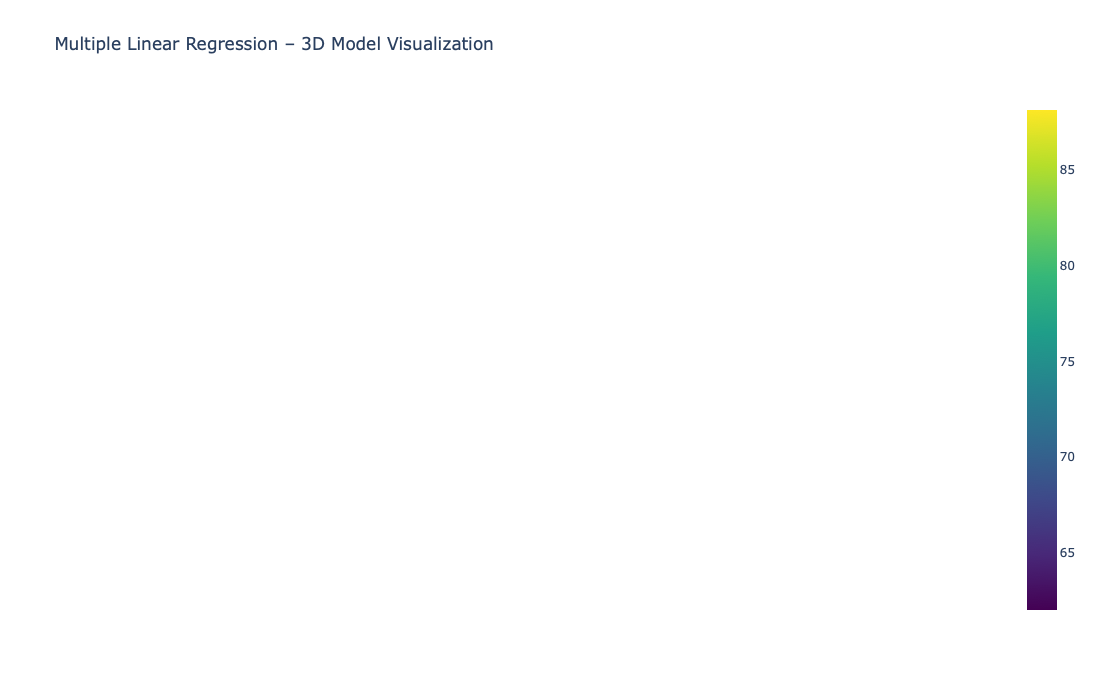

In [16]:
import plotly.graph_objects as go

# Tahmin fonksiyonu
def predict(study, cls, repeat):
    X = np.column_stack([study, cls, repeat])
    return multi_reg.predict(X)

# Grid oluştur
study_range = np.linspace(df['study_hours'].min(), df['study_hours'].max(), 30)
repeat_range = np.linspace(df['repeat_count'].min(), df['repeat_count'].max(), 30)

study_grid, repeat_grid = np.meshgrid(study_range, repeat_range)
class_value = df['class'].mode()[0]  # sınıf değerini en çok görülen sınıfa sabitle

Z = predict(
    study_grid.reshape(-1,1),
    np.full_like(study_grid.reshape(-1,1), class_value),
    repeat_grid.reshape(-1,1)
).reshape(study_grid.shape)

# Scatter (gerçek veri)
scatter3d = go.Scatter3d(
    x=df['study_hours'],
    y=df['repeat_count'],
    z=df['exam_score'],
    mode='markers',
    marker=dict(size=4, color='red'),
    name='Gerçek Veriler'
)

# Surface (model yüzeyi)
surface = go.Surface(
    x=study_range,
    y=repeat_range,
    z=Z,
    colorscale='Viridis',
    opacity=0.7,
    name='Model Surface'
)

fig = go.Figure(data=[surface, scatter3d])

fig.update_layout(
    title="Multiple Linear Regression – 3D Model Visualization",
    scene=dict(
        xaxis_title="Study Hours",
        yaxis_title="Repeat Count",
        zaxis_title="Predicted Exam Score"
    ),
    width=900,
    height=700
)

fig.show()

In [17]:
from sklearn.model_selection import KFold, cross_val_score

# K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores_lin = cross_val_score(lin_reg, X_hours, y, cv=kf, scoring='r2')
scores_poly = cross_val_score(poly_model, X_hours, y, cv=kf, scoring='r2')
scores_multi = cross_val_score(multi_reg, X_multi, y, cv=kf, scoring='r2')

# RMSE
rmse_lin = np.sqrt(mean_squared_error(y, y_pred_lin))
rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
rmse_multi = np.sqrt(mean_squared_error(y, y_pred_multi))

metrics = {
    'Model': [
        'Linear (hours)',
        'Polynomial (hours^2)',
        'Multiple (hours+class+repeat)'
    ],
    'R2_train': [
        r2_score(y, y_pred_lin),
        r2_score(y, y_pred_poly),
        r2_score(y, y_pred_multi)
    ],
    'RMSE_train': [
        rmse_lin,
        rmse_poly,
        rmse_multi
    ],
    'CV_R2_mean': [
        scores_lin.mean(),
        scores_poly.mean(),
        scores_multi.mean()
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,R2_train,RMSE_train,CV_R2_mean
0,Linear (hours),0.060465,19.046083,-0.810402
1,Polynomial (hours^2),0.243197,17.093881,-0.638388
2,Multiple (hours+class+repeat),0.161304,17.994989,-0.830858


In [18]:
hours_to_pred = np.array([[0.5],
                          [1.0],
                          [1.5],
                          [2.0],
                         [2.5],
                         [3.0]])

pred_lin = lin_reg.predict(hours_to_pred)
pred_poly = poly_model.predict(hours_to_pred)

# Çoklu model için: örnek senaryo → class = 1, repeat_count = 1
hours_flat = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
X_multi_pred = np.column_stack([
    hours_flat,
    np.ones_like(hours_flat),      # class = 1
    np.ones_like(hours_flat)       # repeat_count = 1
])

pred_multi = multi_reg.predict(X_multi_pred)

pred_df = pd.DataFrame({
    'study_hours': hours_flat,
    'Linear': np.round(pred_lin, 2),
    'Polynomial': np.round(pred_poly, 2),
    'Multiple (class=1, repeat=1)': np.round(pred_multi, 2)
})
pred_df

,study_hours,Linear,Polynomial,"Multiple (class=1, repeat=1)"
0,0.5,68.38,61.46,63.73
1,1.0,70.29,71.08,65.91
2,1.5,72.19,78.45,68.09
3,2.0,74.10,83.58,70.27
4,2.5,76.01,86.46,72.45
5,3.0,77.92,87.10,74.63


In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Linear model scores
r2_lin = r2_score(y, lin_reg.predict(X_hours))
rmse_lin = mean_squared_error(y, lin_reg.predict(X_hours), squared=False)
mae_lin = mean_absolute_error(y, lin_reg.predict(X_hours))

# Polynomial model scores
r2_poly = r2_score(y, poly_model.predict(X_poly))
rmse_poly = mean_squared_error(y, poly_model.predict(X_poly), squared=False)
mae_poly = mean_absolute_error(y, poly_model.predict(X_poly))

# Multiple regression scores
r2_multi = r2_score(y, multi_reg.predict(X_multi))
rmse_multi = mean_squared_error(y, multi_reg.predict(X_multi), squared=False)
mae_multi = mean_absolute_error(y, multi_reg.predict(X_multi))

print("Linear:", r2_lin, rmse_lin, mae_lin)
print("Poly:", r2_poly, rmse_poly, mae_poly)
print("Multi:", r2_multi, rmse_multi, mae_multi)

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
#Modelleri sonra kullanmak icin kaydet
import joblib

joblib.dump(lin_reg, "lin_reg.pkl")
joblib.dump(poly_model, "poly_model.pkl")
joblib.dump(multi_reg, "multi_reg.pkl")

print("Modeller kaydedildi.")